<h1 align = "center"> Análisis de pobreza multidimensional en Colombia - 2018 </h1>
    
Marlijar Hurtado Moreno - Jhon Sebastián Vela Salcedo

Vamos a clasificar la pobreza en Colombia, por medio de la pobreza multidimensional.

"La medición de la pobreza se hace tradicionalmente de forma directa e indirecta, siguiendo la
clasificación de Amartya Sen (1981). El método directo evalúa los resultados de satisfacción (o
no privación) que tiene un individuo respecto a ciertas características que se consideran
vitales como salud, educación, empleo, entre otras. La medición indirecta evalúa la capacidad
de adquisición de bienes y servicios que tienen los hogares. " DANE

El IPM, tiene 5 dimensiones con 15 variables. Que se componen así:

I - Condiciones educativas: 
    1. Analfabetismo.
    2. Bajo logro educativo.

II - Condicionales de la niñez y juventud: 
    3. Inasistencia escolar.
    4. Rezago escolar.
    5. Barreras de acceso a servicios de cuidado de la primera infancia.
    6. Trabajo infantil.

III - Trabajo: 
    7. Trabajo informal. 
    8. Desempleo de larga duración.

IV - Salud: 
    9. Sin aseguramiento a salud.
    10. Barreras de acceso a salud dada una necesidad.

V- Condiciones de la vivienda y servicios públicos: 
    11. Sin acceso a fuentes de agua mejorada.
    12. Inadecuada eliminación de excreciones. 
    13. Material inadecuado de pisos.
    14. Material inadecuado de paredes. 
    15. Hacinamiento crítico.

### Criterio del DANE para clasificarlos como pobres

Las 5 dimensiones que componen el IPM involucran 15 indicadores. Los hogares son
considerados pobres multidimensionalmente cuando tienen privación en por lo menos el 33%
de los indicadores1
. La fuente de información para el cálculo de la pobreza multidimensional
es la Encuesta Nacional de Calidad de Vida - ENCV, que tiene representatividad estadística
para los dominios cabeceras y centros poblados y rural disperso y para 8 regiones: Antioquia,
Bogotá, Valle del Cauca, Caribe, Pacífica (sin incluir Valle del Cauca), Central, Oriental, sólo
cabecera para Orinoquía-Amazonía y San Andrés. Así, se calcula el porcentaje de personas en
situación de pobreza multidimensional para 7 de las 9 regiones: Caribe, Oriental, Central,
Pacífica (sin incluir Valle del Cauca), Bogotá, Valle del Cauca y Antioquia. 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import graphviz, pydot
import argparse
import os

from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
print(tf.__version__)

2.2.0


___

<h1 align = "center"> I - Organización de los datos </h1>

In [2]:
data = pd.read_csv("hogares.csv", ";")
print("Dimensión=", data.shape, "Tipo de datos=", type(data))
data.dtypes

Dimensión= (80739, 28) Tipo de datos= <class 'pandas.core.frame.DataFrame'>


periodo                      int64
directorio                   int64
secuencia_encuesta           int64
secuencia_p                  int64
p5010                        int64
p8526                        int64
p8530                        int64
fex_c                       object
region                       int64
personas                     int64
paredes                      int64
pisos                        int64
alcantarillado               int64
acueducto                    int64
empleo_formal                int64
desempleo_larga_duracion     int64
barreras_acceso_salud        int64
aseguramiento_salud          int64
trabajo_infantil             int64
atencion_integral            int64
inasistencia_escolar         int64
rezago_escolar               int64
alfabetismo                  int64
logro_educativo              int64
hacinamiento                 int64
ipm                         object
pobre                        int64
fexp                        object
dtype: object

In [3]:
Educativas = {"I-Analfabetismo" : data.alfabetismo,
              "I-Logro educativo" : data.logro_educativo}

Niñez = {"II-Inasistencia escolar" : data.inasistencia_escolar,
         "II-Rezago escolar" : data.rezago_escolar,
         "II-Atención integral primera infancia" : data.atencion_integral,
         "II-Trabajo infantil" : data.trabajo_infantil}

Trabajo = {"III-Trabajo informal" : data.empleo_formal,
           "III-Desempleo larga duración" : data.desempleo_larga_duracion}

Salud = {"IV-Aseguramiento a salud" : data.aseguramiento_salud,
         "IV-Barreras de acceso a salud" : data.barreras_acceso_salud}

Vivienda = {"V-Acueducto" : data.acueducto,
            "V-Alcantarillado" : data.alcantarillado,
            "V-Pisos" : data.pisos,
            "V-Paredes" : data.paredes,
            "V-Hacinamiento crítico" : data.hacinamiento}

In [4]:
Target = {"Pobre" : data.pobre}
Target = pd.DataFrame(Target)

Features = {**Educativas, **Niñez, **Trabajo, **Salud, **Vivienda}
Features = pd.DataFrame(Features)

Datos = {**Target, **Educativas, **Niñez, **Trabajo, **Salud, **Vivienda}
Datos = pd.DataFrame(Datos)
print("Tamaño Target =", Target.shape , "Tamaño Features =", Features.shape, "Tamaño Datos =", Datos.shape )
Datos.head()

Tamaño Target = (80739, 1) Tamaño Features = (80739, 15) Tamaño Datos = (80739, 16)


,Pobre,I-Analfabetismo,I-Logro educativo,II-Inasistencia escolar,II-Rezago escolar,II-Atención integral primera infancia,II-Trabajo infantil,III-Trabajo informal,III-Desempleo larga duración,IV-Aseguramiento a salud,IV-Barreras de acceso a salud,V-Acueducto,V-Alcantarillado,V-Pisos,V-Paredes,V-Hacinamiento crítico
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0


___

<h1 align = "center"> II - Análisis descriptivo </h1>

In [5]:
Correlaciones = Datos.corr().style.background_gradient(cmap='GnBu', axis =None)
Correlaciones

,Pobre,I-Analfabetismo,I-Logro educativo,II-Inasistencia escolar,II-Rezago escolar,II-Atención integral primera infancia,II-Trabajo infantil,III-Trabajo informal,III-Desempleo larga duración,IV-Aseguramiento a salud,IV-Barreras de acceso a salud,V-Acueducto,V-Alcantarillado,V-Pisos,V-Paredes,V-Hacinamiento crítico
Pobre,1.000000,0.570499,0.430333,0.255409,0.238814,0.107510,0.188326,0.253877,0.161925,0.274115,0.221085,0.298079,0.299196,0.322579,0.158622,0.188739
I-Analfabetismo,0.570499,1.000000,0.350847,0.060518,0.031927,-0.027301,0.039698,0.154420,0.046517,0.034770,0.025130,0.136428,0.145150,0.195717,0.034926,0.029783
I-Logro educativo,0.430333,0.350847,1.000000,0.103980,0.111204,-0.059691,0.079042,0.326358,0.060526,0.022923,0.017823,0.218810,0.147723,0.198405,0.055801,0.028688
II-Inasistencia escolar,0.255409,0.060518,0.103980,1.000000,0.243443,0.062976,0.287087,0.067316,-0.045664,0.101828,0.034494,0.063052,0.066492,0.063493,0.040872,0.121851
II-Rezago escolar,0.238814,0.031927,0.111204,0.243443,1.000000,0.044569,0.210812,0.086186,-0.118892,0.027858,0.058258,0.056098,0.072593,0.071022,0.057439,0.173085
II-Atención integral primera infancia,0.107510,-0.027301,-0.059691,0.062976,0.044569,1.000000,0.002477,0.002397,-0.061678,0.119737,0.024890,0.014137,0.037404,0.020347,0.020407,0.172430
II-Trabajo infantil,0.188326,0.039698,0.079042,0.287087,0.210812,0.002477,1.000000,0.056954,-0.059697,0.033960,0.043489,0.044106,0.030875,0.036475,0.012860,0.040570
III-Trabajo informal,0.253877,0.154420,0.326358,0.067316,0.086186,0.002397,0.056954,1.000000,0.045334,0.134326,0.045568,0.134717,0.115326,0.136019,0.061884,0.073648
III-Desempleo larga duración,0.161925,0.046517,0.060526,-0.045664,-0.118892,-0.061678,-0.059697,0.045334,1.000000,-0.062654,-0.040102,-0.039834,-0.020349,-0.013226,0.006530,-0.070871
IV-Aseguramiento a salud,0.274115,0.034770,0.022923,0.101828,0.027858,0.119737,0.033960,0.134326,-0.062654,1.000000,0.055821,0.027042,0.030824,0.034543,0.010154,0.078415


In [6]:
Estadisticas = Datos.describe().transpose()
Estadisticas

,count,mean,std,min,25%,50%,75%,max
Pobre,80739.0,0.227164,0.419002,0.0,0.0,0.0,0.0,1.0
I-Analfabetismo,80739.0,0.147872,0.354975,0.0,0.0,0.0,0.0,1.0
I-Logro educativo,80739.0,0.565798,0.495655,0.0,0.0,1.0,1.0,1.0
II-Inasistencia escolar,80739.0,0.039411,0.194572,0.0,0.0,0.0,0.0,1.0
II-Rezago escolar,80739.0,0.295867,0.456434,0.0,0.0,0.0,1.0,1.0
II-Atención integral primera infancia,80739.0,0.076840,0.266339,0.0,0.0,0.0,0.0,1.0
II-Trabajo infantil,80739.0,0.026035,0.159239,0.0,0.0,0.0,0.0,1.0
III-Trabajo informal,80739.0,0.810736,0.391721,0.0,1.0,1.0,1.0,1.0
III-Desempleo larga duración,80739.0,0.120970,0.326094,0.0,0.0,0.0,0.0,1.0
IV-Aseguramiento a salud,80739.0,0.108931,0.311555,0.0,0.0,0.0,0.0,1.0


___

<h1 align = "center"> III - Estandarizar los "Features" </h1>

In [7]:
Standard_features = StandardScaler().fit_transform(Features.values)
Data_Standard_features = pd.DataFrame(data = Standard_features, columns = Features.keys()).head()
Data_Standard_features

,I-Analfabetismo,I-Logro educativo,II-Inasistencia escolar,II-Rezago escolar,II-Atención integral primera infancia,II-Trabajo infantil,III-Trabajo informal,III-Desempleo larga duración,IV-Aseguramiento a salud,IV-Barreras de acceso a salud,V-Acueducto,V-Alcantarillado,V-Pisos,V-Paredes,V-Hacinamiento crítico
0,-0.416572,-1.141524,-0.202553,-0.648218,-0.288507,-0.163494,-2.069691,-0.370969,-0.34964,-0.277943,-0.545848,-0.495975,-0.330692,-0.234193,-0.3209
1,-0.416572,0.876022,-0.202553,-0.648218,3.466125,-0.163494,-2.069691,-0.370969,-0.34964,-0.277943,-0.545848,-0.495975,-0.330692,-0.234193,-0.3209
2,-0.416572,0.876022,-0.202553,-0.648218,-0.288507,-0.163494,0.483164,2.695646,-0.34964,-0.277943,1.832011,-0.495975,-0.330692,-0.234193,-0.3209
3,-0.416572,-1.141524,-0.202553,-0.648218,3.466125,-0.163494,-2.069691,-0.370969,-0.34964,-0.277943,1.832011,-0.495975,-0.330692,-0.234193,-0.3209
4,-0.416572,0.876022,-0.202553,-0.648218,-0.288507,-0.163494,0.483164,-0.370969,-0.34964,3.597855,-0.545848,-0.495975,-0.330692,-0.234193,-0.3209


___

<h1 align = "center"> IV - PCA Proyección a 2D </h1>

In [8]:
pca = PCA(n_components=2)
PrincipalComponents = pca.fit_transform(Standard_features)
PrincipalDF = pd.DataFrame(data = PrincipalComponents, columns = ['Componente Principal 1', 'Componente Principal 2'])
PrincipalDF.head()

,Componente Principal 1,Componente Principal 2
0,-2.115671,0.312842
1,-1.109479,0.906213
2,0.120369,-1.805389
3,-1.060264,1.030156
4,-0.296493,0.072660


In [9]:
FinalDF = pd.concat([PrincipalDF, Target], axis = 1)
FinalDF.head()

,Componente Principal 1,Componente Principal 2,Pobre
0,-2.115671,0.312842,0
1,-1.109479,0.906213,0
2,0.120369,-1.805389,1
3,-1.060264,1.030156,0
4,-0.296493,0.072660,0


<h2>- Varianza Explicada con 2 componentes principales</h2>

In [10]:
varianza = pca.explained_variance_ratio_
total = np.array(sum(pca.explained_variance_ratio_))
concatenar = np.hstack((varianza, total))
Nombres = ["Componente Principal 1", "Componente Principal 2", "***Total varianza Explicada***"]
pd.Series(concatenar, index=Nombres)

Componente Principal 1            0.154181
Componente Principal 2            0.101515
***Total varianza Explicada***    0.255696
dtype: float64

<h2> - Visualización de la proyección en 2D </h2>

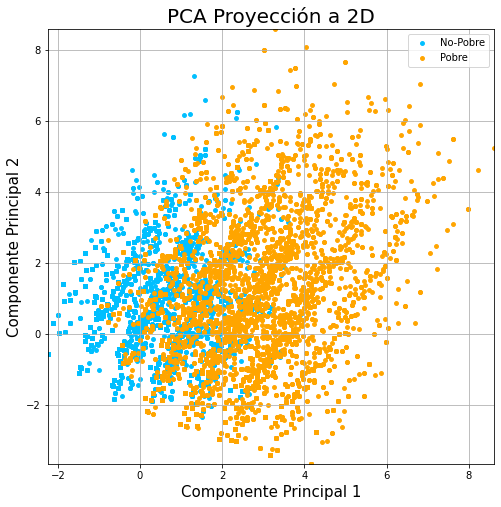

In [11]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlim(min(PrincipalDF["Componente Principal 1"]),max(PrincipalDF["Componente Principal 1"]))
ax.set_ylim(min(PrincipalDF["Componente Principal 2"]),max(PrincipalDF["Componente Principal 2"]))
ax.set_xlabel('Componente Principal 1', fontsize = 15)
ax.set_ylabel('Componente Principal 2', fontsize = 15)
ax.set_title('PCA Proyección a 2D', fontsize = 20)

targets = [0, 1]
colors = ['deepskyblue', 'orange']
for Pobre, color in zip(targets,colors):
    indicesToKeep = FinalDF['Pobre'] == Pobre
    ax.scatter(FinalDF.loc[indicesToKeep, 'Componente Principal 1']
               , FinalDF.loc[indicesToKeep, 'Componente Principal 2']
               , c = color
               , s = 15)

ax.legend(["No-Pobre", "Pobre"])
ax.grid()

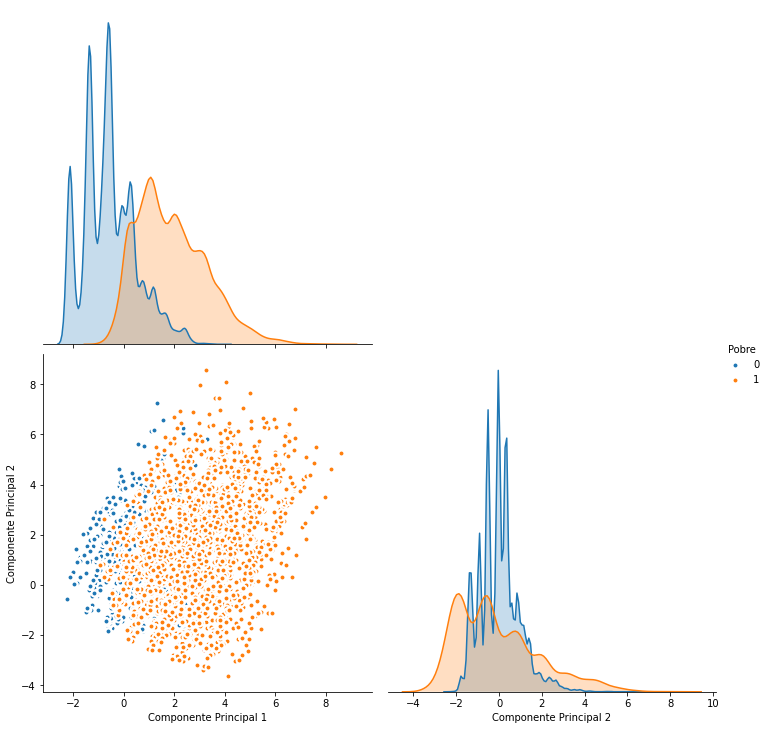

In [12]:
sns.pairplot(FinalDF, hue="Pobre", height=5, corner=True, plot_kws=dict(s=35, linewidth=2));

___

<h1 align = "center"> V - PCA Proyección a 3D </h1>

In [13]:
pca = PCA(n_components=3)
PrincipalComponents = pca.fit_transform(Standard_features)
PrincipalDF = pd.DataFrame(data = PrincipalComponents, 
                           columns = ['Componente Principal 1', 'Componente Principal 2', 'Componente Principal 3'])
PrincipalDF.head()

,Componente Principal 1,Componente Principal 2,Componente Principal 3
0,-2.116102,0.295645,0.677392
1,-1.114415,0.902180,1.157906
2,0.120584,-1.951322,-0.785797
3,-1.056036,0.929224,2.201960
4,-0.296454,0.077328,-0.808572


In [14]:
FinalDF = pd.concat([PrincipalDF, Target], axis = 1)
FinalDF.head()

,Componente Principal 1,Componente Principal 2,Componente Principal 3,Pobre
0,-2.116102,0.295645,0.677392,0
1,-1.114415,0.902180,1.157906,0
2,0.120584,-1.951322,-0.785797,1
3,-1.056036,0.929224,2.201960,0
4,-0.296454,0.077328,-0.808572,0


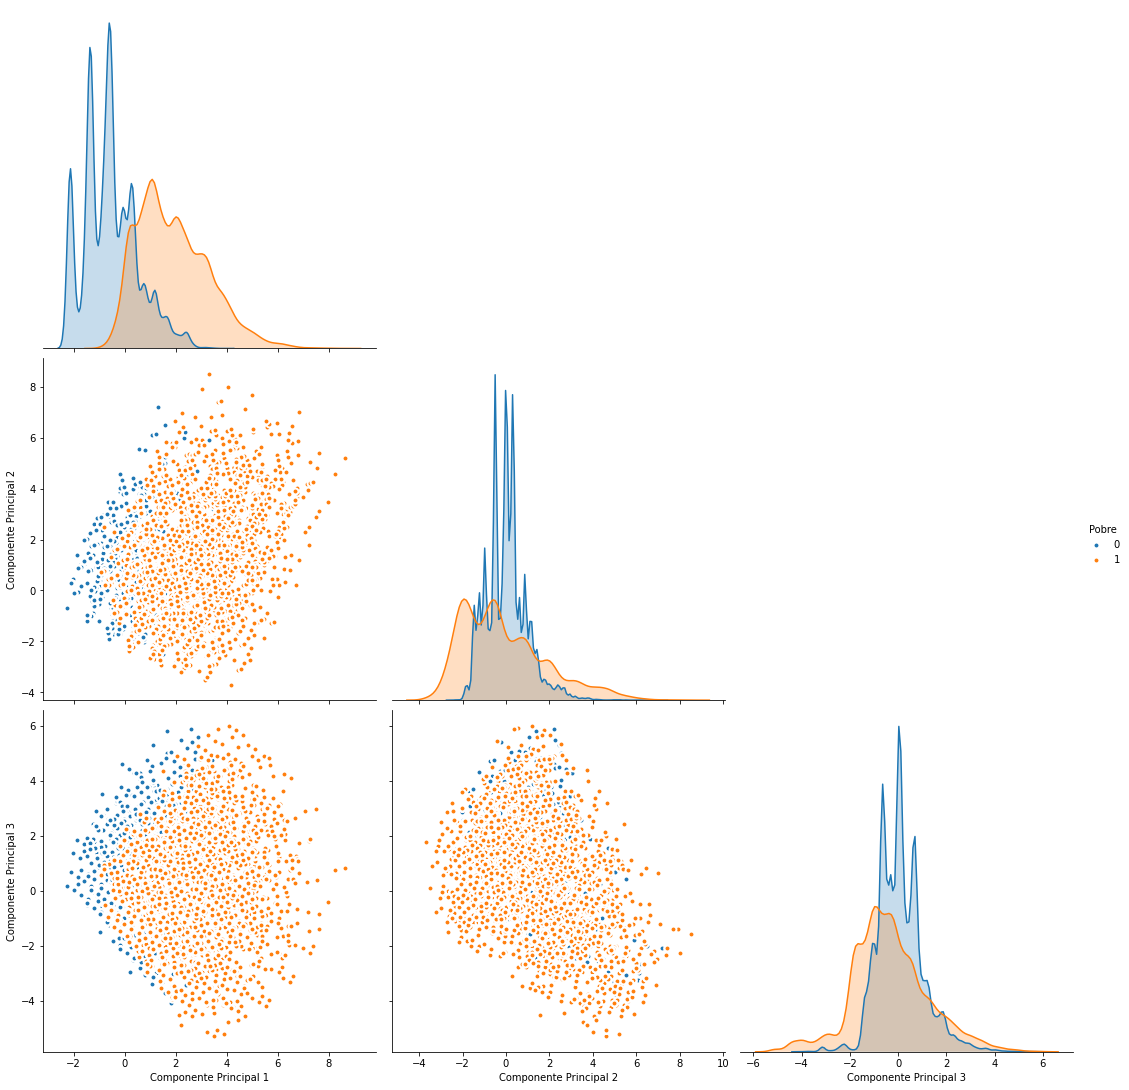

In [15]:
sns.pairplot(FinalDF, hue="Pobre", height=5, corner=True, plot_kws=dict(s=35, linewidth=2))

<h2>- Varianza Explicada con 3 componentes principales</h2>

In [16]:
varianza = pca.explained_variance_ratio_
total = np.array(sum(pca.explained_variance_ratio_))
concatenar = np.hstack((varianza, total))
Nombres = ["Componente Principal 1", "Componente Principal 2", "Componente Principal 3", "***Total varianza Explicada***"]
pd.Series(concatenar, index=Nombres)

Componente Principal 1            0.154181
Componente Principal 2            0.101566
Componente Principal 3            0.086791
***Total varianza Explicada***    0.342538
dtype: float64

<h2> - Visualización de la proyección en 3D </h2>

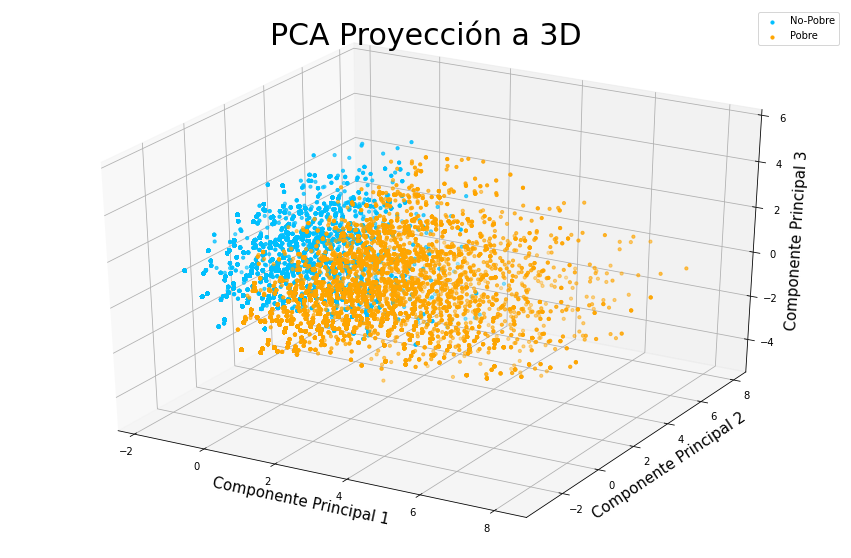

In [17]:
fig = plt.figure()
fig.set_size_inches(15, 10, 10)
ax = fig.add_subplot(111, projection= "3d") 

ax.set_xlim(min(PrincipalDF["Componente Principal 1"]),max(PrincipalDF["Componente Principal 1"]))
ax.set_ylim(min(PrincipalDF["Componente Principal 2"]),max(PrincipalDF["Componente Principal 2"]))
ax.set_zlim(min(PrincipalDF["Componente Principal 3"]),max(PrincipalDF["Componente Principal 3"]))

ax.set_xlabel('Componente Principal 1', fontsize = 15)
ax.set_ylabel('Componente Principal 2', fontsize = 15)
ax.set_zlabel("Componente Principal 3", fontsize = 15)
ax.set_title('PCA Proyección a 3D', fontsize = 30)

targets = [0, 1]
colors = ['deepskyblue', 'orange']
for Pobre, color in zip(targets,colors):
    indicesToKeep = FinalDF['Pobre'] == Pobre
    ax.scatter(FinalDF.loc[indicesToKeep, 'Componente Principal 1'], 
               FinalDF.loc[indicesToKeep, 'Componente Principal 2'], 
               FinalDF.loc[indicesToKeep, 'Componente Principal 3'],
               c = color, 
               s = 10)
ax.legend(["No-Pobre", "Pobre"], fontsize = 10)
ax.grid()

### PCA con 5 componentes

Dado que tenemos 5 dimensiones, vamos a usar un PCA de 5 componentes.

In [18]:
pca = PCA(n_components=15)
PrincipalComponents = pca.fit_transform(Standard_features)
PrincipalDF = pd.DataFrame(data = PrincipalComponents, 
                           columns = ['Componente Principal 1', 'Componente Principal 2', 'Componente Principal 3',
                                     'Componente Principal 4', 'Componente Principal 5', 'Componente Principal 6',
                                     'Componente Principal 7', 'Componente Principal 8', 'Componente Principal 9',
                                     'Componente Principal 10', 'Componente Principal 11', 'Componente Principal 12',
                                     'Componente Principal 13', 'Componente Principal 14', 'Componente Principal 15']
                          )
varianza = pca.explained_variance_ratio_
total = np.array(sum(pca.explained_variance_ratio_))
concatenar = np.hstack((varianza, total))
Nombres = ['Componente Principal 1', 'Componente Principal 2', 'Componente Principal 3','Componente Principal 4', 
           'Componente Principal 5', 'Componente Principal 6', 'Componente Principal 7', 'Componente Principal 8', 
           'Componente Principal 9', 'Componente Principal 10', 'Componente Principal 11', 'Componente Principal 12',
           'Componente Principal 13', 'Componente Principal 14', 'Componente Principal 15', 
           "***Total varianza Explicada***"]

print(pd.Series(concatenar, index=Nombres))
PrincipalDF.head()

Componente Principal 1            0.154182
Componente Principal 2            0.101592
Componente Principal 3            0.086799
Componente Principal 4            0.075617
Componente Principal 5            0.066725
Componente Principal 6            0.065393
Componente Principal 7            0.061408
Componente Principal 8            0.059453
Componente Principal 9            0.056345
Componente Principal 10           0.051862
Componente Principal 11           0.049236
Componente Principal 12           0.047628
Componente Principal 13           0.045601
Componente Principal 14           0.040981
Componente Principal 15           0.037180
***Total varianza Explicada***    1.000000
dtype: float64


,Componente Principal 1,Componente Principal 2,Componente Principal 3,Componente Principal 4,Componente Principal 5,Componente Principal 6,Componente Principal 7,Componente Principal 8,Componente Principal 9,Componente Principal 10,Componente Principal 11,Componente Principal 12,Componente Principal 13,Componente Principal 14,Componente Principal 15
0,-2.116425,0.300927,0.671262,-0.921749,-0.335462,-0.102499,-0.046853,0.384232,1.056785,-0.339017,-0.127153,0.102170,0.000674,0.241839,-0.141177
1,-1.113178,0.877946,1.144340,0.779631,0.116012,-1.124053,-1.219440,2.040988,0.676151,1.923532,-0.302450,-0.481154,-0.177369,0.930247,-1.625084
2,0.118174,-1.907517,-0.803678,0.057953,1.009848,-0.430482,1.004550,1.244872,-1.640693,-0.394018,-0.172983,0.169900,0.048703,1.417502,0.312483
3,-1.056861,0.935813,2.209694,0.195565,-0.874676,-1.587691,-0.423153,2.758171,-0.036802,1.435665,-0.456745,-0.302647,0.045624,1.332628,0.584802
4,-0.296567,0.083492,-0.826930,1.194127,-1.098260,3.188281,0.337723,0.476694,-0.306767,0.611158,0.418918,0.250996,-0.750524,0.291299,-0.699703


___

<h1 align = "center"> VI - Autoencoder </h1>

In [19]:
# Network parameters
original_dim = 15
intermedia_dim = 15
latent_dim = 25

In [20]:
# first build the encoder model
inputs = keras.Input(shape=original_dim, name="encoder_input")

# generate latent vector

intermedia = keras.layers.Dense(intermedia_dim, name= "intermedia", activation="relu") (inputs)

latent = keras.layers.Dense(latent_dim, name= "latent_vector", activation="relu") (intermedia)

# instantiate encoder model
encoder = keras.Model(inputs, 
                      latent,
                      name= "latent_vector")
encoder.summary()
# keras.utils.plot_model(encoder,
#           to_file= "encoder.png",
#           show_shapes= True)

Model: "latent_vector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 15)]              0         
_________________________________________________________________
intermedia (Dense)           (None, 15)                240       
_________________________________________________________________
latent_vector (Dense)        (None, 25)                400       
Total params: 640
Trainable params: 640
Non-trainable params: 0
_________________________________________________________________


In [21]:
# build the decoder model
latent_inputs = keras.layers.Input(shape=latent_dim, name='decoder_input')

# use the shape (15,1) that was earlier saved
intermediate_inputs = keras.layers.Dense(intermedia_dim,
                                         activation='relu',
                                         name='intermediate_inputs')(latent_inputs)

# reconstruct the input
outputs = keras.layers.Dense(original_dim,
                             activation='relu',
                             name='decoder_output')(intermediate_inputs)

# instantiate decoder model
decoder = keras.models.Model(latent_inputs, 
                             outputs, 
                             name='decoder')
decoder.summary()
# keras.utils.plot_model(decoder, 
#                        to_file='decoder.png', 
#                        show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 25)]              0         
_________________________________________________________________
intermediate_inputs (Dense)  (None, 15)                390       
_________________________________________________________________
decoder_output (Dense)       (None, 15)                240       
Total params: 630
Trainable params: 630
Non-trainable params: 0
_________________________________________________________________


In [22]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = keras.models.Model(inputs,
                                 decoder(encoder(inputs)),
                                 name='autoencoder')
autoencoder.summary()
# keras.utils.plot_model(autoencoder,
#                        to_file='autoencoder.png',
#                        show_shapes=True)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 15)]              0         
_________________________________________________________________
latent_vector (Model)        (None, 25)                640       
_________________________________________________________________
decoder (Model)              (None, 15)                630       
Total params: 1,270
Trainable params: 1,270
Non-trainable params: 0
_________________________________________________________________


In [23]:
x_train, x_test, y_train, y_test = train_test_split(Standard_features, Target, test_size = 0.3)
print('Entrenamiento-Features: ', x_train.shape)
print('Validación-Features: ', y_train.shape)
print('Entrenamiento-Target: ', x_test.shape)
print('Validación-Target: ', y_test.shape)

autoencoder.compile(loss='mse', 
                    optimizer='adam', 
                    metrics=['acc'])

class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('acc')>0.93):
                print("\nReached 93% accuracy so cancelling training!")
                self.model.stop_training = True
                
callbacks = myCallback()                
History = autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs= 10,
                batch_size= 50,
                callbacks=[callbacks])

Entrenamiento-Features:  (56517, 15)
Validación-Features:  (56517, 1)
Entrenamiento-Target:  (24222, 15)
Validación-Target:  (24222, 1)
Epoch 1/10
1131/1131 [==============================] - 4s 3ms/step - loss: 0.4778 - acc: 0.6456 - val_loss: 0.3621 - val_acc: 0.7160
Epoch 2/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.3567 - acc: 0.7231 - val_loss: 0.3525 - val_acc: 0.7337
Epoch 3/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.3520 - acc: 0.7315 - val_loss: 0.3503 - val_acc: 0.7386
Epoch 4/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.3508 - acc: 0.7354 - val_loss: 0.3496 - val_acc: 0.7402
Epoch 5/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.3504 - acc: 0.7372 - val_loss: 0.3494 - val_acc: 0.7404
Epoch 6/10
1131/1131 [==============================] - 3s 3ms/step - loss: 0.3502 - acc: 0.7377 - val_loss: 0.3492 - val_acc: 0.7405
Epoch 7/10
1131/1131 [==============================] - 3s 3

<h2> - Análisis Gráfico del ajuste</h2>

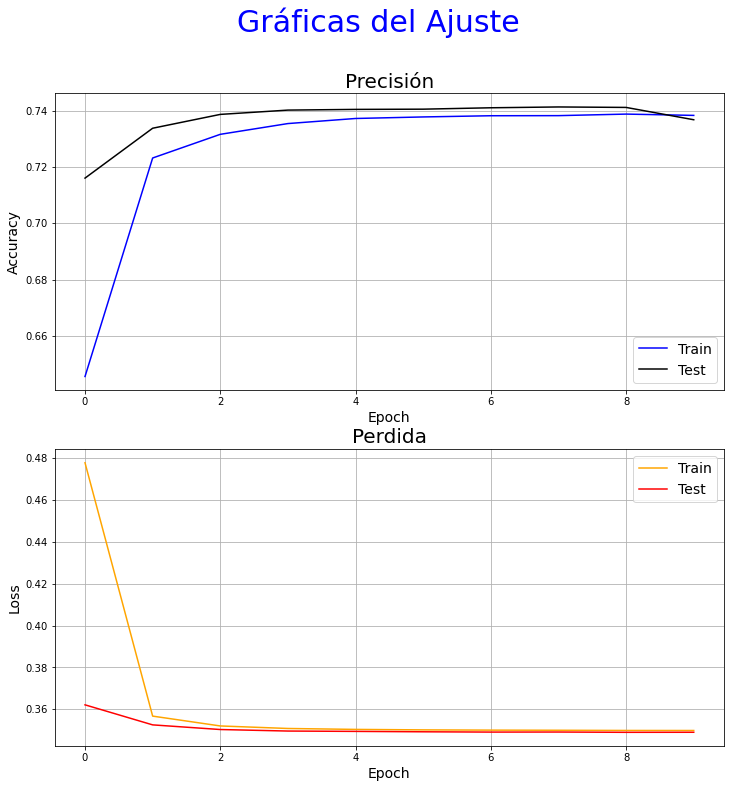

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12))

# Resumen progreso de la Precisión
ax1.plot(History.history['acc'], color= "Blue")
ax1.plot(History.history['val_acc'], color= "Black")
ax1.set_title('Precisión', fontsize= 20)
ax1.set_ylabel('Accuracy', fontsize= 14)
ax1.set_xlabel('Epoch', fontsize= 14)
ax1.legend(['Train', 'Test'], loc='lower right', fontsize= 14)
ax1.grid(True)

# Resumen progreso de Perdida
ax2.plot(History.history['loss'], color= "Orange")
ax2.plot(History.history['val_loss'], color= "Red")
ax2.set_title('Perdida', fontsize= 20)
ax2.set_ylabel('Loss', fontsize= 14)
ax2.set_xlabel('Epoch', fontsize= 14)
ax2.legend(['Train', 'Test'], loc='upper right', fontsize= 14)
ax2.grid(True)

fig.suptitle("Gráficas del Ajuste", fontsize= 30, color= "Blue")
plt.show()

<h1 align = "center"> VII - Autoencoder Variacional (VAE) </h1>

In [25]:
x_train, x_test, y_train, y_test = train_test_split(Features, Target, test_size = 0.3)
print('Entrenamiento-Features: ', x_train.shape)
print('Validación-Features: ', y_train.shape)
print('Entrenamiento-Target: ', x_test.shape)
print('Validación-Target: ', y_test.shape)

Entrenamiento-Features:  (56517, 15)
Validación-Features:  (56517, 1)
Entrenamiento-Target:  (24222, 15)
Validación-Target:  (24222, 1)


In [26]:
# Muestriador
def sampling(args):
    z_mean, z_log_var = args 
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1] 
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [27]:
# network parameters
original_dim = 15
input_shape = original_dim
intermediate_dim = 5
latent_dim = 2

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Ingresar el epsilon muestriado con las medias y la desviación  
z = Lambda(sampling,
           output_shape=(latent_dim,), 
           name='z')([z_mean, z_log_var])

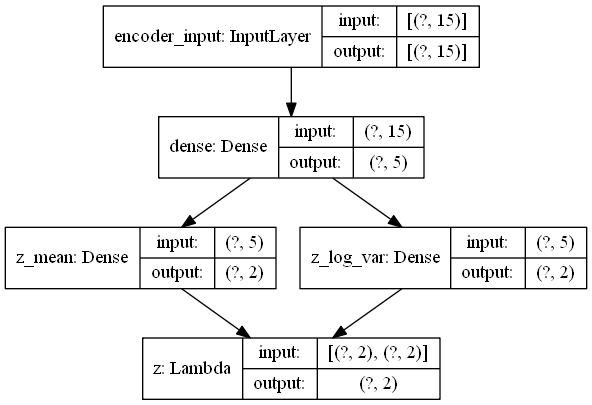

In [28]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
# encoder.summary()
plot_model(encoder,
           to_file='vae_mlp_encoder.png',
           show_shapes=True)

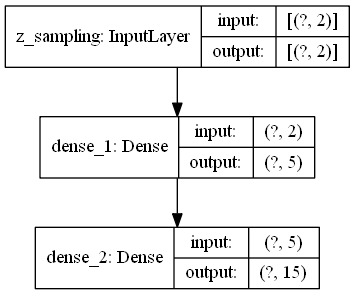

In [29]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
# decoder.summary()
plot_model(decoder,
           to_file='vae_mlp_decoder.png', 
           show_shapes=True)

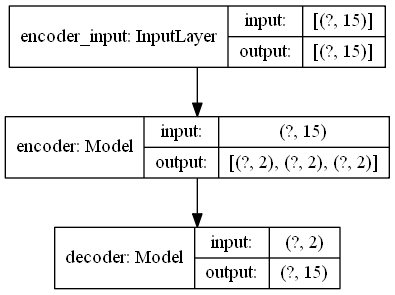

In [30]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
plot_model(vae,to_file='vae_mlp.png', show_shapes=True)

In [31]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    help_ = "Load tf model trained weights"
    parser.add_argument("-w", "--weights", help=help_)
    help_ = "Use binary cross entropy instead of mse (default)"
    parser.add_argument("--bce", help=help_, action='store_true')
    parser.add_argument('-f') # Agrege una dummy para quitar el error
    args = parser.parse_args()
    models = (encoder, decoder)
    data = (x_test, y_test)

    # VAE loss = mse_loss or xent_loss + kl_loss
    if args.bce:
        reconstruction_loss = binary_crossentropy(inputs,
                                                  outputs)
    else:
        reconstruction_loss = mse(inputs, outputs) 

    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    compile = vae.compile(optimizer='adam', 
               metrics = [tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)])
#     vae.summary()
    save_dir = "vae_cnn_weights"
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    if args.weights:
        filepath = os.path.join(save_dir, args.weights)
        vae = vae.load_weights(filepath)
    else:
        # train the autoencoder
        history = vae.fit(x_train, x_train,
                epochs=5,
                batch_size=10,
                validation_data=(x_test, x_test))
        filepath = os.path.join(save_dir, 'vae')
        vae.save_weights(filepath)

Epoch 1/5
5652/5652 [==============================] - 16s 3ms/step - loss: 1.8503 - binary_accuracy: 0.8436 - val_loss: 1.6926 - val_binary_accuracy: 0.8551
Epoch 2/5
5652/5652 [==============================] - 16s 3ms/step - loss: 1.6994 - binary_accuracy: 0.8543 - val_loss: 1.6923 - val_binary_accuracy: 0.8551
Epoch 3/5
5652/5652 [==============================] - 17s 3ms/step - loss: 1.6989 - binary_accuracy: 0.8543 - val_loss: 1.6914 - val_binary_accuracy: 0.8551
Epoch 4/5
5652/5652 [==============================] - 17s 3ms/step - loss: 1.6987 - binary_accuracy: 0.8543 - val_loss: 1.6924 - val_binary_accuracy: 0.8551
Epoch 5/5
5652/5652 [==============================] - 16s 3ms/step - loss: 1.6987 - binary_accuracy: 0.8543 - val_loss: 1.6912 - val_binary_accuracy: 0.8551


## BinaryAccuracy class

Calculates how often predictions matches binary labels.

This metric creates two local variables, total and count that are used to compute the frequency with which y_pred matches y_true. This frequency is ultimately returned as binary accuracy: an idempotent operation that simply divides total by count.

If sample_weight is None, weights default to 1. Use sample_weight of 0 to mask values.

Arguments

name: (Optional) string name of the metric instance.
dtype: (Optional) data type of the metric result.
threshold: (Optional) Float representing the threshold for deciding whether prediction values are 1 or 0.

In [32]:
history.model.get_layer

<bound method Network.get_layer of <tensorflow.python.keras.engine.training.Model object at 0x000001F8AC6A1388>>